## ロジスティック回帰分析

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

### データセット

試験情報の閲覧経験および試験勉強の時間により試験結果を予測する。

|　| 閲覧経験 | 勉強時間 | 試験結果 |
:---:|:---:|:---:|:---:|
|**0**| 1.0 | 24.0 | 1.0 |
|**1**| 1.0 | 18.0 | 1.0 |
|**2**| 0.0 | 15.0 | 1.0 |
|**3**| 1.0 | 16.0 | 1.0 |
|：|：|：|：|

＜特徴量X＞\
閲覧経験: 試験に関係する情報を閲覧したか否か(0: 閲覧経験なし、1: 閲覧経験あり)\
勉強時間: 試験に関係する勉強時間

＜目的変数y＞\
試験結果: 試験の結果(0: 試験不合格、1: 試験合格)

＜特徴量の詳細＞
- 試験勉強にあたり、教科書や問題集にて勉強時間を割くとする。


- 試験対策にあたり、インターネットや情報商材にて傾向や対策を得たかを閲覧経験とする。

[データセットの作成にあたって参考にしたサイト](https://bellcurve.jp/statistics/blog/8607.html)

In [2]:
#read csv file 
data = np.loadtxt('log_sample.csv', delimiter=',', skiprows=1)

In [3]:
data.shape

(26, 3)

In [4]:
x_columns = ['browse_experiences', 'hours_of_study', 'exam_results']
data_frame = pd.DataFrame(data, columns=x_columns)
data_frame

,browse_experiences,hours_of_study,exam_results
0,1.0,24.0,1.0
1,1.0,18.0,1.0
2,0.0,15.0,1.0
3,1.0,16.0,1.0
4,0.0,10.0,1.0
5,1.0,26.0,1.0
6,1.0,2.0,1.0
7,0.0,24.0,1.0
8,1.0,18.0,1.0
9,1.0,22.0,1.0


In [5]:
#特徴量X
X = data[:, 0:2]
#目的変数y
y = data[:, 2]

In [6]:
#正規化
def normalize_x_features(X):
    X_norm = np.zeros((X.shape[0], X.shape[1]))
    mean = np.zeros((1, X.shape[1]))
    std = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mean[:, i] = np.mean(X[:, i])
        std[:, i] = np.std(X[:, i])
        X_norm[:, i] = (X[:, i] - float(mean[:, i])) / float(std[:, i])
    return X_norm, mean, std

In [7]:
X_norm, mean, std = normalize_x_features(X)

In [8]:
X_norm[0:5, :]

array([[ 0.85634884,  1.72405807],
       [ 0.85634884,  0.83052631],
       [-1.16774842,  0.38376043],
       [ 0.85634884,  0.53268239],
       [-1.16774842, -0.36084936]])

In [9]:
print(X_norm.mean())
print(X_norm.std())

-1.4144668342580118e-17
1.0


### 特徴量エンジニアリング(EDA)

データセットの前提

- 試験情報の閲覧経験がある者の方が、ない者と比較して、試験に合格する可能性が高い。


- 試験勉強に時間を費やした者の方が、ない者と比較して、試験に合格する可能性が高い。

Text(0.5, 1.0, 'Pass Rate')

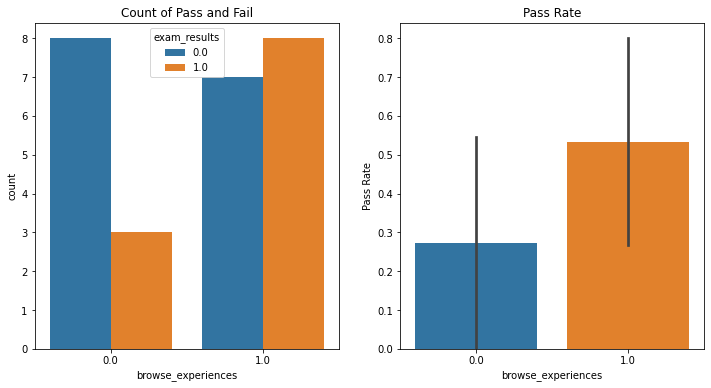

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
left = sns.countplot(x='browse_experiences',
                  hue='exam_results',
                  data=data_frame,
                  ax=axes[0])

right = sns.barplot(x='browse_experiences',
                  y='exam_results',
                  data=data_frame,
                  ax=axes[1]).set_ylabel('Pass Rate')

axes[0].set_title('Count of Pass and Fail')
axes[1].set_title('Pass Rate')

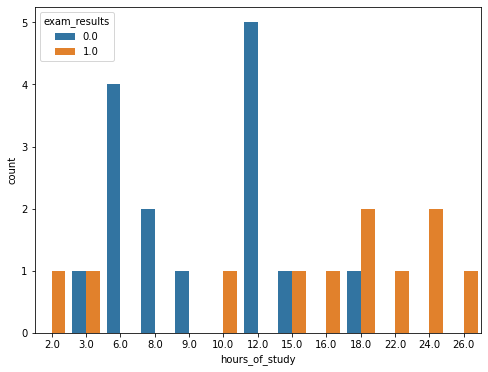

In [11]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="hours_of_study", hue="exam_results", data=data_frame)
plt.show()

Text(0.5, 1.0, 'Density of Pass and Fail')

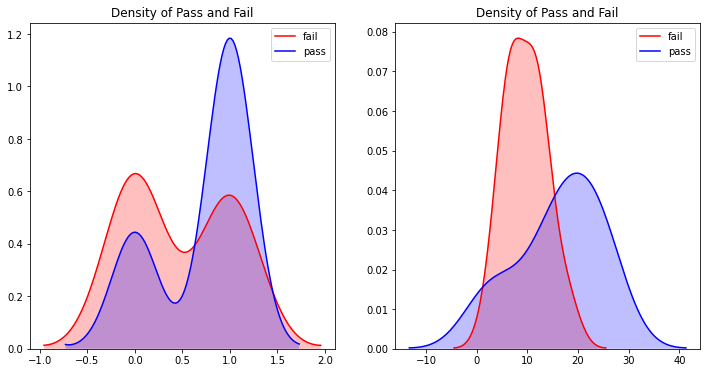

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

left_fail = sns.kdeplot(data_frame['browse_experiences'][data_frame['exam_results'] == 0],
                        shade=True, color="r", label='fail', ax=axes[0])
left_pass = sns.kdeplot(data_frame['browse_experiences'][data_frame['exam_results'] == 1],
                        shade=True, color="b", label='pass', ax=axes[0])

right_fail = sns.kdeplot(data_frame['hours_of_study'][data_frame['exam_results'] == 0],
                         shade=True, color="r", label='fail', ax=axes[1])
right_pass = sns.kdeplot(data_frame['hours_of_study'][data_frame['exam_results'] == 1],
                         shade=True, color="b", label='pass', ax=axes[1])


axes[0].set_title('Density of Pass and Fail')
axes[1].set_title('Density of Pass and Fail')

### クラス実装

In [13]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れる場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    lambda_ : float
    　L2正則化パラメータ
    to_pickle_ : bool
    　学習した重みの保存有無

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, bias, verbose, lambda_=1.0, to_pickle_=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.lambda_ = lambda_
        self.bias = bias
        self.verbose = verbose
        self.to_pickle_ = to_pickle_
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def __add_x0(self, X):
        """
        バイアス項を入れる場合、
        値1を特徴量Xの1列目に結合
        """
        x0 = np.ones((X.shape[0], 1))
        return np.concatenate((x0, X), axis=1)
    
    def __sigmoid_function(self, X):
        """
        シグモイド関数にて仮定関数を計算
        """
        return 1 / (1 + np.exp(-np.dot(X, self.theta)))               
       
    def __gradient_descent(self, X, y, h):
        """
        パラメータtheta更新用のメソッド

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
          訓練データの正解値
        h : 次の形のndarray, shape (n_samples, )
        　シグモイド関数の出力結果

        Returns
        -------
        self.theta：回帰係数ベクトル shape (n_features, )

        """
        m = len(y)
        gradient = np.dot(X.T, (h - y)) / m

        if self.bias:
            l2norm = (self.lambda_ / m) * self.theta
            l2norm[0] = 0 #切片の列は0
            self.theta -= self.lr * gradient + l2norm
        else:
            l2norm = (self.lambda_ / m) * self.theta
            self.theta -= self.lr * gradient + l2norm
            
        return self.theta    

    def __loss_function(self, h, y):
        """
        損失関数を計算
        """
        m = len(y)
        loss = np.sum((-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() +
                      (self.lambda_ * np.square(self.theta)) / (2 * m))
        
        return loss

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.bias:
            X = self.__add_x0(X)
            if not(X_val is None) and not(y_val is None):
                X_val = self.__add_x0(X_val)

        self.theta = np.random.rand(X.shape[1])

        for i in range(self.iter):
            h = self.__sigmoid_function(X)
            self.theta = self.__gradient_descent(X, y, h)
            self.loss[i] = self.__loss_function(h, y)

            if not(X_val is None) and not(y_val is None):
                h_val = self.__sigmoid_function(X_val)
                self.val_loss[i] = self.__loss_function(h_val, y_val)

            if self.verbose:
                #verboseをTrueにした場合は学習過程を出力
                print("Training Data" + "*"*40)
                print("theta:{}".format(self.theta))
                print("loss:{}".format(self.loss[i]))
                if not(X_val is None) and not(y_val is None):
                    print("Validation Data" + "*"*40)
                    print("theta:{}".format(self.theta))
                    print("loss in cost function:{}".format(self.val_loss[i])) 
        
        if self.to_pickle_:
            pickle_obj = self.theta
            pd.to_pickle(pickle_obj, 'pickle_obj.pkl')

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias:
            X = self.__add_x0(X)
    
        return self.__sigmoid_function(X)
    
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        return self.predict_proba(X).round()

### 【問題1】仮定関数

ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z)=\frac{1}{1 + e^{-z}}
$$


線形回帰の仮定関数は次の式でした。

$$
h_{\theta(x)}=\theta^T.x.
$$


まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_{\theta(x)}=\frac{1}{1 + e^{-\theta^T.x.}}
$$


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル

### 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_{j}:=\theta_{j}-α\frac{\delta J(\theta)}{\delta\theta_{j}}
$$

$$
\frac{\delta J(\theta)}{\delta\theta_{0}}=\theta_{j}-\frac{1}{m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)},j = 0
$$

$$
\frac{\delta J(\theta)}{\delta\theta_{0}}=(\theta_{j}-\frac{1}{m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)})+\frac{\lambda}{m}\theta_{j},j \geq 1
$$


$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

### 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

### 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。

$$
J(\theta)=\frac{1}{m}\displaystyle \sum_{i=1}^m
[-y^{(i)}\log(h_{\theta}(x^{(i)})) -(1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))] +
\frac{\lambda}{2m}\displaystyle \sum_{j=1}^n \theta_{j}^2.
$$


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$n$ : 特徴量の数


$λ$ : 正則化パラメータ

In [14]:
model = ScratchLogisticRegression(num_iter=100, lr=0.1, bias=True, verbose=True)
model.fit(X_norm, y)

Training Data****************************************
theta:[0.11290085 0.65572472 0.29085507]
loss:1.8680199498452321
Training Data****************************************
theta:[0.1026811  0.6272625  0.29554554]
loss:1.8584523961526878
Training Data****************************************
theta:[0.09268807 0.60052093 0.29994645]
loss:1.8500073891222097
Training Data****************************************
theta:[0.08291915 0.57540051 0.30407616]
loss:1.8425556222891002
Training Data****************************************
theta:[0.07337134 0.5518068  0.30795197]
loss:1.8359815759110554
Training Data****************************************
theta:[0.06404142 0.52965025 0.31159013]
loss:1.8301822756740707
Training Data****************************************
theta:[0.05492593 0.50884606 0.31500591]
loss:1.8250661151970364
Training Data****************************************
theta:[0.04602123 0.489314   0.31821358]
loss:1.8205517506121822
Training Data***********************************

In [15]:
y_pred = model.predict(X_norm)
y_pred_proba = model.predict_proba(X_norm)

In [16]:
y_pred

array([1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
y_pred_proba

array([0.62847987, 0.5484181 , 0.40999702, 0.52093973, 0.34521018,
       0.65388813, 0.33414324, 0.53323889, 0.5484181 , 0.60234072,
       0.34654337, 0.38495753, 0.40999702, 0.37058975, 0.38495753,
       0.29710804, 0.46576899, 0.37058975, 0.5484181 , 0.34654337,
       0.4114232 , 0.33283346, 0.37058975, 0.29710804, 0.32068315,
       0.46576899])

In [18]:
def evaluate(y_test, y_pred):
    """
    2値分類の評価指標を計算・描画する。
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    plt.figure(figsize=(1.6, 1.2))
    cm_def = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_def, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    return acc, precision, recall, f1

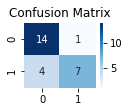

Accuracy : 0.81
Precision : 0.88
Recall : 0.64
F1 : 0.74



In [19]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y, y_pred)))

### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

#### irisデータセット

In [20]:
iris_dataset = load_iris()

In [21]:
#オリジナルデータの作成
x_origin_columns = ['sepal_length', 'petal_length']
X_origin = pd.DataFrame(iris_dataset.data[:,[0,2]], columns=x_origin_columns)
y_origin = pd.DataFrame(iris_dataset.target, columns=['Species'])
df_origin = pd.concat([X_origin, y_origin], axis=1)

In [22]:
rows_to_drop = df_origin.index[df_origin['Species'] == 0 ] #'setosa'の行を削除
df = df_origin.drop(rows_to_drop, axis=0).reset_index(drop=True)
iris_mapping = {1: 0, 2: 1} #'versicolor'を0,  'virginica'を1にマッピング
df['Species'] = df['Species'].map(iris_mapping)
X = df.iloc[:, :-1].to_numpy()
y = df.loc[:, 'Species'].to_numpy()

- 前処理・訓練データと検証データの分割

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)

- 前処理・標準化

In [24]:
scaler = StandardScaler()

In [25]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
X_train_scaled = scaler.transform(X_train)

In [27]:
X_test_scaled = scaler.transform(X_test)

1. scikit-learn ロジスティック回帰

In [28]:
scikit_model = SGDClassifier(loss="log")
scikit_model.fit(X_train_scaled, y_train.ravel())
scikit_pred = scikit_model.predict(X_test_scaled)
scikit_pred_proba = scikit_model.predict_proba(X_test_scaled)

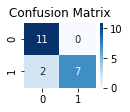

Accuracy : 0.90
Precision : 1.00
Recall : 0.78
F1 : 0.88



In [29]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, scikit_pred)))

2. scratch ロジスティック回帰

In [30]:
scratch_model = ScratchLogisticRegression(num_iter=100, lr=0.1, bias=True, verbose=True)
scratch_model.fit(X_train_scaled, y_train.ravel(), X_test_scaled, y_test.ravel())
scratch_pred = scratch_model.predict(X_test_scaled)
scratch_pred_proba = scratch_model.predict_proba(X_test_scaled)

Training Data****************************************
theta:[0.63942287 0.36358146 0.12863747]
loss:1.9049144503751514
Validation Data****************************************
theta:[0.63942287 0.36358146 0.12863747]
loss in cost function:1.9538694731266044
Training Data****************************************
theta:[0.62598702 0.37320155 0.15817196]
loss:1.8655775339219267
Validation Data****************************************
theta:[0.62598702 0.37320155 0.15817196]
loss in cost function:1.913793754463031
Training Data****************************************
theta:[0.61295911 0.38202306 0.18656514]
loss:1.829005232253381
Validation Data****************************************
theta:[0.61295911 0.38202306 0.18656514]
loss in cost function:1.8767372587727367
Training Data****************************************
theta:[0.60032886 0.39009831 0.21387454]
loss:1.7949594019630593
Validation Data****************************************
theta:[0.60032886 0.39009831 0.21387454]
loss in cost fu

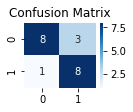

Accuracy : 0.80
Precision : 0.73
Recall : 0.89
F1 : 0.80



In [31]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, scratch_pred)))

### 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

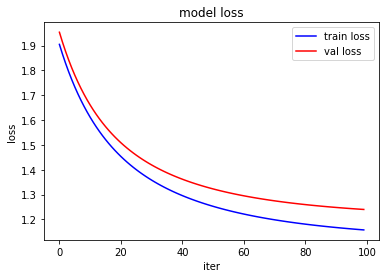

In [32]:
plt.figure()
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")

x_plot = range(0, scratch_model.iter)
plt.plot(x_plot, scratch_model.loss, '-', color="b", label="train loss")
plt.plot(x_plot, scratch_model.val_loss, '-', color="r", label="val loss")

plt.legend(loc="best")

plt.show()

### 【問題7】決定領域の可視化
決定領域を可視化してください。

In [33]:
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='sepal_length', ylabel='petal_length', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5,
                                              np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5,
                                              np.max(X[:,1])+0.5, step))

    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [34]:
scikit_pred, scratch_pred

(array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 0.]))

In [35]:
scikit_pred_proba.shape, scratch_pred_proba.shape

((20, 2), (20,))

In [36]:
scikit_model, scratch_model

(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
               n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
               random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 <__main__.ScratchLogisticRegression at 0x7fc902ea3810>)

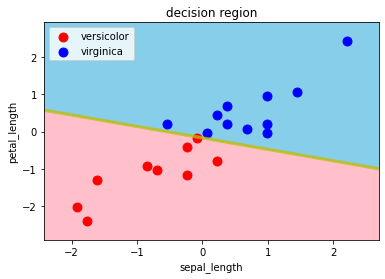

In [37]:
decision_region(X_test_scaled, scratch_pred, scratch_model)

### 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。


[pickle — Python オブジェクトの直列化 — Python 3.7.4 ドキュメント](https://docs.python.org/ja/3/library/pickle.html)


[numpy.savez — NumPy v1.17 Manual](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)

In [38]:
scratch_model = ScratchLogisticRegression(num_iter=100, lr=0.1,
                                          bias=True, verbose=False,
                                          to_pickle_=True)
scratch_model.fit(X_train_scaled, y_train.ravel())

In [39]:
pickle_obj = pd.read_pickle('pickle_obj.pkl')
print(pickle_obj)

[0.2209552  0.29110823 1.12448204]
